In [204]:
# %autosave 0

# 4. Evaluation Metrics for Classification

In the previous session we trained a model for predicting churn. How do we know if it's good?


## 4.1 Evaluation metrics: session overview 

* Dataset: https://www.kaggle.com/blastchar/telco-customer-churn
* https://raw.githubusercontent.com/alexeygrigorev/mlbookcamp-code/master/chapter-03-churn-prediction/WA_Fn-UseC_-Telco-Customer-Churn.csv


*Metric* - function that compares the predictions with the actual values and outputs a single number that tells how good the predictions are

Source: https://knowmledge.com/2023/10/02/ml-zoomcamp-2023-evaluation-metrics-for-classification-part-1/

In [205]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

In [206]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LogisticRegression

In [207]:
# Read the dataset and store it in the 'df' dataframe
df = pd.read_csv('data-week-3.csv')

# Standardize column names by converting them to lowercase and replacing spaces with underscores
df.columns = df.columns.str.lower().str.replace(' ', '_')

# Identify categorical columns (columns with object data type)
categorical_columns = list(df.dtypes[df.dtypes == 'object'].index)

# Standardize categorical column values by converting them to lowercase and replacing spaces with underscores
for c in categorical_columns:
    df[c] = df[c].str.lower().str.replace(' ', '_')

# Convert 'totalcharges' column to numerical format (it was mistakenly identified as categorical)
# 'errors="coerce"' ensures that non-numeric values are turned into NaN instead of raising errors
df.totalcharges = pd.to_numeric(df.totalcharges, errors='coerce')

# Replace NaN values in 'totalcharges' with 0
df.totalcharges = df.totalcharges.fillna(0)

# Convert 'churn' column to integer format: 'yes' -> 1, 'no' -> 0
df.churn = (df.churn == 'yes').astype(int)


In [208]:
# Split the dataset into 'df_full_train' (80%) and 'df_test' (20%)
# 'random_state=1' ensures the split is reproducible
df_full_train, df_test = train_test_split(df, test_size=0.2, random_state=1)

# Further split 'df_full_train' into 'df_train' (60%) and 'df_val' (20%)
# This results in an overall split of 60% training, 20% validation, and 20% testing
df_train, df_val = train_test_split(df_full_train, test_size=0.25, random_state=1)

# Reset the indices for all datasets to ensure they have continuous indices
# 'drop=True' removes the old index to avoid confusion
df_train = df_train.reset_index(drop=True)
df_val = df_val.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)

# Extract the target variable ('churn') from each dataset
y_train = df_train.churn.values
y_val = df_val.churn.values
y_test = df_test.churn.values

# Remove the 'churn' column from feature datasets to prevent data leakage during training
del df_train['churn']
del df_val['churn']
del df_test['churn']

In [209]:
# ‘numerical’ and ‘categorical’ contain the relevant column names. The ‘numerical’ array contains the names of all numerical columns, 
# while the ‘categorical’ array contains the names of all categorical columns.
numerical = ['tenure', 'monthlycharges', 'totalcharges']

categorical = [
    'gender',
    'seniorcitizen',
    'partner',
    'dependents',
    'phoneservice',
    'multiplelines',
    'internetservice',
    'onlinesecurity',
    'onlinebackup',
    'deviceprotection',
    'techsupport',
    'streamingtv',
    'streamingmovies',
    'contract',
    'paperlessbilling',
    'paymentmethod',
]

In [294]:
# Create an instance of DictVectorizer with sparse=False to return dense arrays
dv = DictVectorizer(sparse=False)

# Convert the training dataframe into a list of dictionaries (one dictionary per record)
# This format is required by DictVectorizer to process the data
train_dict = df_train[categorical + numerical].to_dict(orient='records')

# Fit the DictVectorizer to the training data and transform it into a feature matrix
# 'fit_transform' learns the structure of the data, including column names and values
# It performs one-hot encoding for categorical values but ignores numeric values
X_train = dv.fit_transform(train_dict)

# Create a Logistic Regression model
model = LogisticRegression(max_iter=5000)

# Train the model using the transformed training data and corresponding target values
model.fit(X_train, y_train)


LogisticRegression(max_iter=5000)

In [211]:
# Convert the validation DataFrame into a list of dictionaries (one dictionary per record)
# This transformation is necessary for DictVectorizer to process the validation data
val_dict = df_val[categorical + numerical].to_dict(orient='records')

# Transform the validation data using the trained DictVectorizer
# Unlike training, we only use 'transform' here since the DictVectorizer is already fitted
X_val = dv.transform(val_dict)

# Predict probabilities using the trained model
# 'predict_proba' returns two columns: probability of class 0 and class 1
# We extract the second column, which represents the probability of churn (class 1)
y_pred = model.predict_proba(X_val)[:, 1]

# Make churn decisions based on a threshold of 0.5
# If the predicted probability is >= 0.5, churn_decision is True; otherwise, it is False
churn_decision = (y_pred >= 0.5)

# Calculate the model's accuracy by comparing predicted churn decisions with actual values
# The 'mean' function computes the proportion of correct predictions
(y_val == churn_decision).mean()


np.float64(0.801277501774308)

## 4.2 Accuracy and dummy model

source: https://knowmledge.com/2023/10/03/ml-zoomcamp-2023-evaluation-metrics-for-classification-part-2/

#### In the last article, we calculated that our model achieved an accuracy of 80% on the validation data. 
#### Now, let’s determine whether this is a good value or not.

### What we will do

* Evaluate the model on different thresholds
* Check the accuracy of dummy baselines

We evaluated the model’s predictions on the validation dataset using a 0.5 threshold for churn. Customers with predicted values ≥ 0.5 were classified as churning, while those below were non-churning. Out of 1409 customers, 1132 were correctly predicted, resulting in an accuracy of 80% (1132/1409). Whether this accuracy is sufficient depends on the context and problem requirements.

In [212]:
len(y_val)

1409

In [213]:
(y_val == churn_decision).mean()

np.float64(0.801277501774308)

In [214]:
1132/ 1409

0.8034066713981547

### Evaluate the model on different thresholds

In [215]:
from sklearn.metrics import accuracy_score

In [216]:
accuracy_score(y_val, y_pred >= 0.5)

0.801277501774308

To determine the best threshold, we can adjust it and revalidate the model. Using NumPy’s linspace, we generate multiple threshold values (e.g., 21 evenly spaced between 0 and 1). For each threshold, we calculate accuracy and select the best one based on validation results. This fine-tuning helps optimize the model’s performance.

In [217]:
thresholds = np.linspace(0, 1, 21)

scores = []

for t in thresholds:
    score = accuracy_score(y_val, y_pred >= t)
    print('%.2f %.3f' % (t, score))
    scores.append(score)

0.00 0.274
0.05 0.509
0.10 0.598
0.15 0.664
0.20 0.707
0.25 0.737
0.30 0.759
0.35 0.766
0.40 0.780
0.45 0.793
0.50 0.801
0.55 0.798
0.60 0.797
0.65 0.784
0.70 0.765
0.75 0.744
0.80 0.730
0.85 0.726
0.90 0.726
0.95 0.726
1.00 0.726


The validation results confirm that 0.5 is the best threshold, making it a suitable choice for our model. To visualize the optimization process, we can plot threshold values on the x-axis and accuracy (or another metric) on the y-axis. This helps illustrate how model performance changes with different thresholds, making it easier to identify the optimal value

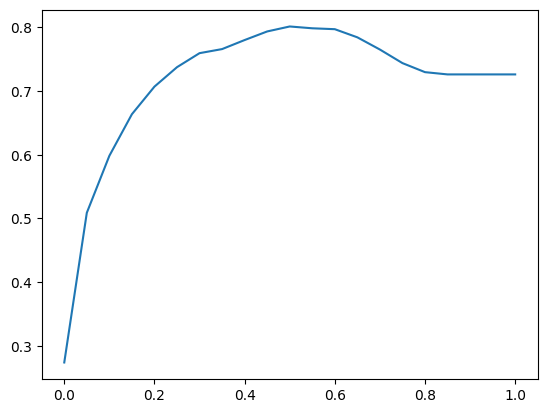

In [218]:
plt.plot(thresholds, scores)

### Check Accuracy of Dummy Baseline

There is an important point about the limitations of accuracy as an evaluation metric. Accuracy alone may not fully reflect a model’s performance, especially with imbalanced datasets or when certain errors are more critical. While our model has 80% accuracy, a dummy model predicting all customers as non-churning still achieves 73%, showing accuracy’s limitations. In churn prediction, false negatives (missed churners) are often more costly than false positives. The best evaluation metric depends on the problem—when false negatives matter more, metrics like recall may be more appropriate.

In [219]:
from collections import Counter

In [220]:
Counter(y_pred >= 1.0)

Counter({np.False_: 1409})

In [221]:
# Distribution of y_val
Counter(y_val)

Counter({np.int64(0): 1023, np.int64(1): 386})

In [222]:
1023/1409

0.7260468417317246

In [223]:
y_val.mean()

np.float64(0.2739531582682754)

In [224]:
1 - y_val.mean()

np.float64(0.7260468417317246)

The dataset has a class imbalance, with 27% churning customers and 73% non-churning customers. This makes accuracy misleading, as a dummy model predicting only the majority class could still achieve high accuracy while failing to identify the minority class (churning customers). To address this, alternative metrics should be used:

* Precision: Measures true positive predictions among all positive predictions, useful when false positives are costly.
* Recall: Measures true positive predictions among actual positives, important when false negatives are costly.
* F1-Score: Balances precision and recall, considering both false positives and negatives.
* AUC-ROC: Assesses the ability to distinguish between classes, particularly helpful for imbalanced datasets.


Choosing the right metric depends on the problem’s goals, with an emphasis on accurately identifying the minority class in cases of imbalance.

## 4.3 Confusion table / matrix

(source: https://knowmledge.com/2023/10/04/ml-zoomcamp-2023-evaluation-metrics-for-classification-part-3/)

A confusion matrix is a tool used to check how well a classification model is working. It helps us see the mistakes and correct predictions the model makes.

Sometimes, using only accuracy can be misleading, especially if the classes are imbalanced (one class appears much more than the other). The confusion matrix gives a better way to evaluate the model by breaking predictions into four types:
* True Positives (TP): The model correctly predicted the positive class (churning customers).
* True Negatives (TN): The model correctly predicted the negative class (non-churning customers).
* False Positives (FP): The model wrongly predicted the positive class (Type I error).
* False Negatives (FN): The model wrongly predicted the negative class (Type II error).


| g(xi) < t (NEGATIVE – NO CHURN) | g(xi) < t (NEGATIVE – NO CHURN) | g(xi) >= t (POSITIVE – CHURN) | g(xi) >= t (POSITIVE – CHURN) |
|----------------------------------|----------------------------------|--------------------------------|--------------------------------|
| **C didn’t churn** | **C churned** | **C didn’t churn** | **C churned** |
| correct | incorrect | incorrect | correct |
| **TRUE NEGATIVE (TN)** | **FALSE NEGATIVE (FN)** | **FALSE POSITIVE (FP)** | **TRUE POSITIVE (TP)** |
| g(xi) < t & y = 0 | g(xi) < t & y = 1 | g(xi) >= t & y = 0 | g(xi) >= t & y = 1 |



Here, we will do the following:

* Different types of errors and correct decisions
* Arranging them in a table


### Different types of errors and correct decisions

In [225]:
# people who are going to churn
actual_positive = (y_val == 1)
# people who are not going to churn
actual_negative = (y_val == 0)

In [226]:
t = 0.5
predict_positive = (y_pred >= t)
predict_negative = (y_pred < t)

We examine the cases where both “predict_positive” and “actual_positive” are true. This is precisely what the “&” operator represents, indicating a logical AND operation.

In [227]:
predict_positive & actual_positive

array([False, False, False, ..., False,  True,  True])

In [228]:
tp = (predict_positive & actual_positive).sum()
tp

np.int64(214)

In [229]:
tn = (predict_negative & actual_negative).sum()
tn

np.int64(915)

In [230]:
fp = (predict_positive & actual_negative).sum()
fp

np.int64(108)

In [231]:
fn = (predict_negative & actual_positive).sum()
fn

np.int64(172)

### Arranging them in a table

That was preparation for understanding the confusion matrix. The confusion matrix is a way to consolidate all these values (tp, tn, fp, fn) into a single table. This table comprises 4 cells, forming a 2×2 matrix.

* In the columns of this table, we have the predictions (NEGATIVE: g(xi) < t and POSITIVE: g(xi) >= t).
* In the rows, we have the actual values (NEGATIVE: y=0 and POSITIVE: y=1).

Now, let’s proceed to implement this confusion matrix in NumPy.

In [232]:
confusion_matrix = np.array([
    [tn, fp],
    [fn, tp]
])
confusion_matrix

array([[915, 108],
       [172, 214]])

|                | **NO CHURN** <br> *(g(xi) < t) NEGATIVE* | **CHURN** <br> *(g(xi) >= t) POSITIVE* |
|:--------------:|:--------------------------------:|:-----------------------------:|
| **NO CHURN** <br> *y=0 NEGATIVE* | **True Negative TN** <br> 922 <br> **65%** | **False Positive FP** <br> 101 <br> **8%** |
| **CHURN** <br> *y=1 POSITIVE*   | **False Negative FN** <br> 176 <br> **12%** | **True Positive TP** <br> 210 <br> **15%** |


We observe that we have more false negatives than false positives. False positives represent customers who receive the email even though they are not likely to churn, resulting in a loss of money due to unnecessary discounts. False negatives are customers who do not receive the email and end up leaving, causing financial losses as well. Both situations are undesirable.

Instead of using absolute numbers, we can also express these values in relative terms to gain a better perspective on the model’s performance.

In [233]:
(confusion_matrix / confusion_matrix.sum()).round(2)

array([[0.65, 0.08],
       [0.12, 0.15]])

## 4.4 Precision and Recall

(source: https://knowmledge.com/2023/10/05/ml-zoomcamp-2023-evaluation-metrics-for-classification-part-4/)


Precision and Recall are essential metrics for evaluating binary classification models.

**Precision** measures the fraction of positive predictions that were correct. In other words, it quantifies how accurately the model predicts customers who are likely to churn.

Precision = True Positives / (# Positive Predictions) = True Positives / (True Positives + False Positives)

**Recall**, on the other hand, quantifies the fraction of actual positive cases that were correctly identified by the model. It assesses how effectively the model captures all customers who are actually churning.

Recall = True Positives / (# Positive Observations) = True Positives / (True Positives + False Negatives)

In summary, precision focuses on the accuracy of positive predictions, while recall emphasizes the model’s ability to capture all positive cases. These metrics are crucial for understanding the trade-offs between correctly identifying churning customers and minimizing false positives.

| **Actual Values**        | **Negative Predictions** <br> *(g(xi) < t)* | **Positive Predictions** <br> *(g(xi) >= t)* |
|:------------------------:|:--------------------------------:|:-----------------------------:|
| **Negative Example** <br> *y=0* | **TN** | **FP** |
| **Positive Example** <br> *y=1* | **FN** | **TP** |
<p style="text-align: center">Confusion Matrix Recall = TP / (TP + FN) &nbsp;&nbsp; Precision = TP / (TP + FP)</p>

In [234]:
accuracy = (tp + tn) / (tp + tn + fp + fn)
accuracy

np.float64(0.801277501774308)

In [235]:
precision = tp / (tp + fp)
precision

np.float64(0.6645962732919255)

In [236]:
# --> promotional email goes to 311 people, but 210 are actually going to churn (--> 33% are mistakes)
tp + fp

np.int64(322)

In [237]:
recall = tp / (tp + fn)
recall

np.float64(0.5544041450777202)

In [238]:
# --> For 46% of people who are churning we failed to identify them
tp + fn

np.int64(386)

Accuracy alone can be misleading, especially with class imbalance. **Precision** and **recall** give a clearer picture by measuring how well the model identifies positive cases (churning customers).  

When it's crucial to detect specific cases—like preventing customer churn—precision and recall help balance correctly identifying positives while minimizing false positives and false negatives. Relying only on accuracy may not fully reflect the model’s effectiveness.

## 4.5 ROC Curves

(source: https://knowmledge.com/2023/10/06/ml-zoomcamp-2023-evaluation-metrics-for-classification-part-5/)

ROC (Receiver Operating Characteristic) curves help evaluate how well a binary classification model distinguishes between two classes. They show the trade-off between false positives and true positives at different decision thresholds.

The curve is created by plotting True Positive Rate (TPR) against False Positive Rate (FPR) for different thresholds. The AUC-ROC (Area Under the Curve - ROC) measures overall performance—higher values mean better model discrimination.

ROC curves help choose the best threshold by balancing false positives and true positives based on the problem’s needs.

| Actual Values     | Negative Predictions (g(xᵢ) < t) | Positive Predictions (g(xᵢ) ≥ t) |
|:----------------:|:--------------------------------:|:--------------------------------:|
| **Negative Example (y=0)** | **TN** | **FP** |
|  |  | **FPR = FP / (TN + FP)** |
| **Positive Example (y=1)** | **FN** | **TP** |
|  |  | **TPR = TP / (FN + TP)** |

<p style="text-align: center">Confusion matrix: FPR – False Positive Rate, TPR – True Positive Rate</p>


### TPR and FRP

In [239]:
tpr = tp / (tp + fn)
tpr

np.float64(0.5544041450777202)

In [240]:
fpr = fp / (fp + tn)
fpr

np.float64(0.10557184750733138)

In [241]:
# The ROC curve is a useful visualization tool that allows you to assess the performance of a binary classification model across a range of decision thresholds.

scores = []

thresholds = np.linspace(0, 1, 101)

for t in thresholds:
    actual_positive = (y_val == 1)
    actual_negative = (y_val == 0)
    
    predict_positive = (y_pred >= t)
    predict_negative = (y_pred < t)

    tp = (predict_positive & actual_positive).sum()
    tn = (predict_negative & actual_negative).sum()

    fp = (predict_positive & actual_negative).sum()
    fn = (predict_negative & actual_positive).sum()
    
    scores.append((t, tp, fp, fn, tn))
# scores

In [242]:
columns = ['threshold', 'tp', 'fp', 'fn', 'tn']
df_scores = pd.DataFrame(scores, columns=columns)
df_scores

threshold   tp    fp   fn    tn
0         0.00  386  1023    0     0
1         0.01  385   903    1   120
2         0.02  384   812    2   211
3         0.03  382   753    4   270
4         0.04  380   708    6   315
..         ...  ...   ...  ...   ...
96        0.96    0     0  386  1023
97        0.97    0     0  386  1023
98        0.98    0     0  386  1023
99        0.99    0     0  386  1023
100       1.00    0     0  386  1023

[101 rows x 5 columns]

In [243]:
# We can look at each tenth record by using this column 10 operator. This works by printing every record starting from the 
# first record and moving forward with increments of 10.
df_scores[::10]

threshold   tp    fp   fn    tn
0          0.0  386  1023    0     0
10         0.1  367   547   19   476
20         0.2  334   361   52   662
30         0.3  291   244   95   779
40         0.4  253   177  133   846
50         0.5  214   108  172   915
60         0.6  153    53  233   970
70         0.7   69    14  317  1009
80         0.8    5     0  381  1023
90         0.9    0     0  386  1023
100        1.0    0     0  386  1023

In [244]:
df_scores['tpr'] = df_scores.tp / (df_scores.tp + df_scores.fn)
df_scores['fpr'] = df_scores.fp / (df_scores.fp + df_scores.tn)
df_scores[::10]

threshold   tp    fp   fn    tn       tpr       fpr
0          0.0  386  1023    0     0  1.000000  1.000000
10         0.1  367   547   19   476  0.950777  0.534702
20         0.2  334   361   52   662  0.865285  0.352884
30         0.3  291   244   95   779  0.753886  0.238514
40         0.4  253   177  133   846  0.655440  0.173021
50         0.5  214   108  172   915  0.554404  0.105572
60         0.6  153    53  233   970  0.396373  0.051808
70         0.7   69    14  317  1009  0.178756  0.013685
80         0.8    5     0  381  1023  0.012953  0.000000
90         0.9    0     0  386  1023  0.000000  0.000000
100        1.0    0     0  386  1023  0.000000  0.000000

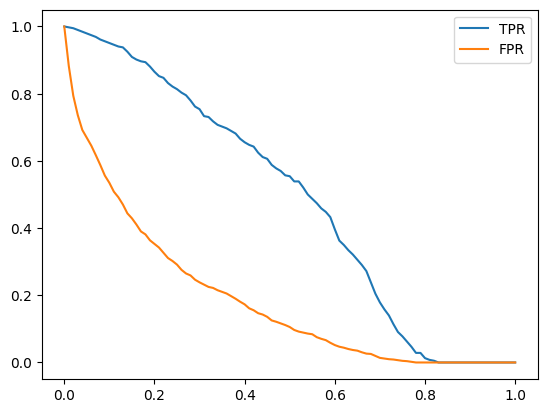

In [245]:
plt.plot(df_scores.threshold, df_scores['tpr'], label='TPR')
plt.plot(df_scores.threshold, df_scores['fpr'], label='FPR')
plt.legend()

### Random model

In [246]:
np.random.seed(1)
y_rand = np.random.uniform(0, 1, size=len(y_val))
y_rand.round(3)

array([0.417, 0.72 , 0.   , ..., 0.774, 0.334, 0.089])

In [247]:
# Accuracy for our random model is around 50%
((y_rand >= 0.5) == y_val).mean()

np.float64(0.5017743080198722)

In [248]:
#Let’s put the previously used code into a function.
def tpr_fpr_dataframe(y_val, y_pred):
    scores = []

    thresholds = np.linspace(0, 1, 101)

    for t in thresholds:
        actual_positive = (y_val == 1)
        actual_negative = (y_val == 0)

        predict_positive = (y_pred >= t)
        predict_negative = (y_pred < t)

        tp = (predict_positive & actual_positive).sum()
        tn = (predict_negative & actual_negative).sum()

        fp = (predict_positive & actual_negative).sum()
        fn = (predict_negative & actual_positive).sum()

        scores.append((t, tp, fp, fn, tn))

    columns = ['threshold', 'tp', 'fp', 'fn', 'tn']
    df_scores = pd.DataFrame(scores, columns=columns)

    df_scores['tpr'] = df_scores.tp / (df_scores.tp + df_scores.fn)
    df_scores['fpr'] = df_scores.fp / (df_scores.fp + df_scores.tn)
    
    return df_scores

In [249]:
df_rand = tpr_fpr_dataframe(y_val, y_rand)
df_rand[::10]

threshold   tp    fp   fn    tn       tpr       fpr
0          0.0  386  1023    0     0  1.000000  1.000000
10         0.1  347   923   39   100  0.898964  0.902248
20         0.2  307   822   79   201  0.795337  0.803519
30         0.3  276   724  110   299  0.715026  0.707722
40         0.4  237   624  149   399  0.613990  0.609971
50         0.5  202   518  184   505  0.523316  0.506354
60         0.6  161   409  225   614  0.417098  0.399804
70         0.7  121   302  265   721  0.313472  0.295210
80         0.8   78   206  308   817  0.202073  0.201369
90         0.9   40   101  346   922  0.103627  0.098729
100        1.0    0     0  386  1023  0.000000  0.000000

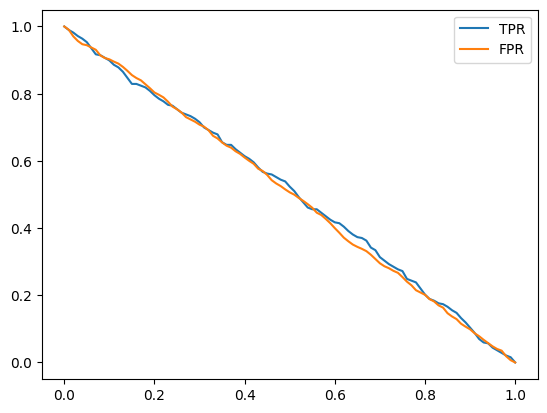

In [250]:
plt.plot(df_rand.threshold, df_rand['tpr'], label='TPR')
plt.plot(df_rand.threshold, df_rand['fpr'], label='FPR')
plt.legend()

### Ideal model

Now, let’s discuss the concept of an ideal model that makes correct predictions for every example. To implement this, we need to determine the number of negative examples, which corresponds to the number of people who are not churning in our dataset.

In [251]:
num_neg = (y_val == 0).sum()
num_pos = (y_val == 1).sum()
num_neg, num_pos

(np.int64(1023), np.int64(386))

To create the ideal model’s predictions for our validation set, we first create a y_ideal array that contains only negative observations (0s) followed by positive observations (1s). We use the np.repeat() function to achieve this, creating an array with 1023 zeros and then 386 ones.

In [252]:
y_ideal = np.repeat([0, 1], [num_neg, num_pos])
y_ideal

array([0, 0, 0, ..., 1, 1, 1])

To create our predictions for the ideal model, which are numbers between 0 and 1, we can use the np.linspace() function to generate an array of evenly spaced values between 0 and 1. This array should have the same length as y_ideal, which is 1409 in this case.

In [253]:
y_ideal_pred = np.linspace(0, 1, len(y_val))
y_ideal_pred

array([0.00000000e+00, 7.10227273e-04, 1.42045455e-03, ...,
       9.98579545e-01, 9.99289773e-01, 1.00000000e+00])

In [254]:
1 - y_val.mean()

np.float64(0.7260468417317246)

In [255]:
accuracy_ideal = ((y_ideal_pred >= 0.726) == y_ideal).mean()
accuracy_ideal

np.float64(1.0)

The ideal model, which makes perfect predictions, doesn’t exist in reality, but it serves as a benchmark to understand how well our actual model is performing. By comparing our model’s performance to that of the ideal model, we can assess how much room for improvement there is.

In [256]:
df_ideal = tpr_fpr_dataframe(y_ideal, y_ideal_pred)
df_ideal[::10]

threshold   tp    fp   fn    tn       tpr       fpr
0          0.0  386  1023    0     0  1.000000  1.000000
10         0.1  386   882    0   141  1.000000  0.862170
20         0.2  386   741    0   282  1.000000  0.724340
30         0.3  386   600    0   423  1.000000  0.586510
40         0.4  386   459    0   564  1.000000  0.448680
50         0.5  386   319    0   704  1.000000  0.311828
60         0.6  386   178    0   845  1.000000  0.173998
70         0.7  386    37    0   986  1.000000  0.036168
80         0.8  282     0  104  1023  0.730570  0.000000
90         0.9  141     0  245  1023  0.365285  0.000000
100        1.0    1     0  385  1023  0.002591  0.000000

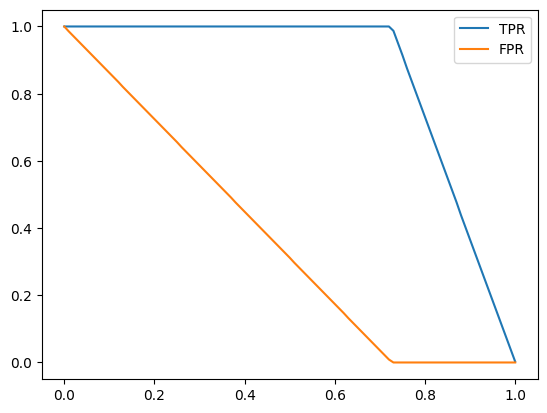

In [257]:
plt.plot(df_ideal.threshold, df_ideal['tpr'], label='TPR')
plt.plot(df_ideal.threshold, df_ideal['fpr'], label='FPR')
plt.legend()

What we see here is that TPR almost always stays around 1 and starts to go down after the threshold of 0.726. So, this model can correctly identify churning customers up to that threshold. For people who are not churning but are classified as churning by the model when the threshold is below 0.726, the model is not always correct. However, the detection becomes always true after the threshold of 0.726.

Let’s take another example with a threshold of 0.4. The FPR is around 45%, and the model makes some mistakes. So, for around 32% of people who are predicted as non-churning when the threshold is set to 0.726 but are below that threshold, we predict them as churning even though they are not.

### Putting everything together
Now let’s try to plot all the models together so we can hold the benchmarks together.

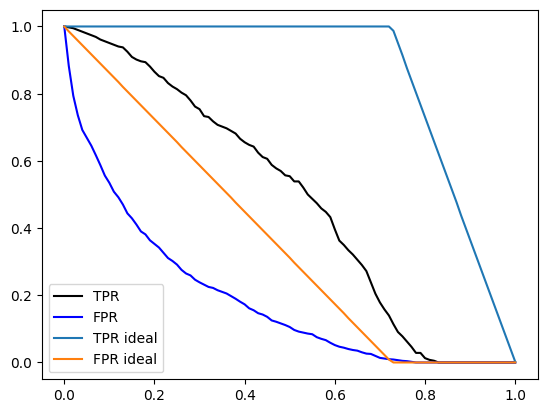

In [258]:
plt.plot(df_scores.threshold, df_scores['tpr'], label='TPR', color='black')
plt.plot(df_scores.threshold, df_scores['fpr'], label='FPR', color='blue')

# plt.plot(df_rand.threshold, df_rand['tpr'], label='TPR random', color='grey')
# plt.plot(df_rand.threshold, df_rand['fpr'], label='FPR random', color='grey')

plt.plot(df_ideal.threshold, df_ideal['tpr'], label='TPR ideal')
plt.plot(df_ideal.threshold, df_ideal['fpr'], label='FPR ideal')

plt.legend()

We see that our TPR is far from the ideal model. We want it to be as close as possible to 1. We also notice that our FPR is significantly different from that of the ideal model. Plotting against the threshold is not always intuitive. For example, in our model, the best threshold is 0.5, as we know from accuracy. However, for the ideal model, as we saw earlier, the best threshold is 0.726. So they have different thresholds. What we can do to better visualize this is to plot FPR against TPR. On the x-axis, we’ll have FPR, and on the y-axis, we’ll have TPR. To make it easier to understand, we can also add the benchmark lines.

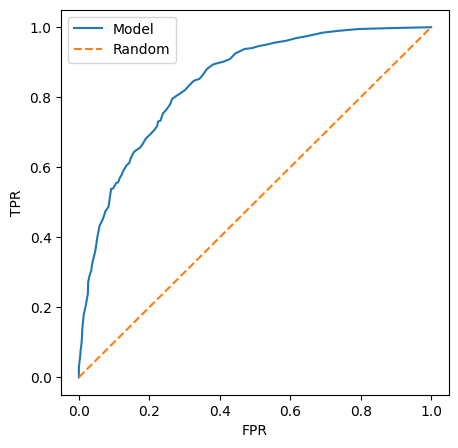

In [259]:
plt.figure(figsize=(5, 5))

plt.plot(df_scores.fpr, df_scores.tpr, label='Model')
plt.plot([0, 1], [0, 1], label='Random', linestyle='--')

plt.xlabel('FPR')
plt.ylabel('TPR')

plt.legend()

In the curve of the ideal model, there is one crucial point, often referred to as the ‘north star’ or ideal spot, located in the upper-left corner where TPR is 100% and FPR is 0%. This point represents the optimal performance we aim to achieve with our model. A ROC curve visualizes this by plotting TPR against FPR, and we usually add a diagonal random baseline. Our goal is to make our model’s curve as close as possible to this ideal spot, which means simultaneously being as far away as possible from the random baseline. In essence, if our model closely resembles the random baseline model, it is not performing well.

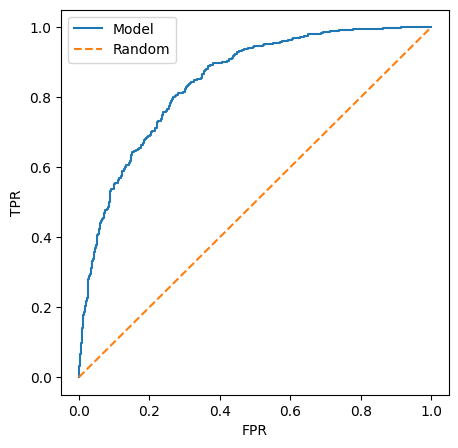

In [260]:
### We can also use the ROC functionality of scikit learn package
from sklearn.metrics import roc_curve
fpr, tpr, thresholds = roc_curve(y_val, y_pred)
plt.figure(figsize=(5, 5))

plt.plot(fpr, tpr, label='Model')
plt.plot([0, 1], [0, 1], label='Random', linestyle='--')

plt.xlabel('FPR')
plt.ylabel('TPR')

plt.legend()

#### What kind of information do we get from ROC curve?

ROC curves show how a model works at different thresholds. Here’s a simple breakdown:

1. **Starting Point (Lower-Left Corner):**
   - **Threshold = 1.0**: The model is very strict. It predicts *no one* will churn (all are non-churning).
   - **TPR (True Positive Rate) = 0**: No churning customers are correctly identified.
   - **FPR (False Positive Rate) = 0**: No mistakes (no non-churning customers are wrongly labeled as churning).

2. **Moving Right (Lower Thresholds):**
   - As the threshold drops, the model predicts *more* customers will churn.
   - **TPR increases**: More churning customers are correctly found.
   - **FPR increases**: More non-churning customers are wrongly labeled as churning.

3. **Ending Point (Upper-Right Corner):**
   - **Threshold = 0.0**: The model predicts *everyone* will churn.
   - **TPR = 100%**: All churning customers are found.
   - **FPR = 100%**: All non-ch customersurning are wrongly labeled as churning.

4. **What the Curve Shows:**
   - Each point on the ROC curve represents a different threshold.
   - A curve closer to the top-left corner (ideal) means the model works well.
   - A curve close to the diagonal line (random baseline) means the model is no better than guessing.

5. **AUC (Area Under the Curve):**
   - AUC measures the overall performance of the model.
   - Higher AUC = better at distinguishing churning vs. non-churning customers.

In short, ROC curves help pick the best threshold to balance finding true churning customers (high TPR) while avoiding false alarms (low FPR).

## 4.6 ROC AUC

(source: https://knowmledge.com/2023/10/07/ml-zoomcamp-2023-evaluation-metrics-for-classification-part-6/)

* Area under the ROC curve - useful metric
* Interpretation of AUC

One way to quantify how close we are to the ideal point is by measuring the area under the ROC curve (AUC). AUC equals 0.5 for a random baseline and 1.0 for an ideal curve. Therefore, our model’s AUC should fall between 0.5 and 1.0. When AUC is less than 0.5, we’ve made a mistake. AUC = 0.8 is considered good, while 0.9 is great, but 0.6 is considered poor. We can calculate AUC using the scikit-learn package. This package is not specifically for roc curves, this is for any curve. It can calculate area under any curve.

#### Useful metric

In [261]:
from sklearn.metrics import auc

In [262]:
# auc needs values for x-axis and y-axis
auc(fpr, tpr)

np.float64(0.8445038720820102)

In [263]:
auc(df_scores.fpr, df_scores.tpr)

np.float64(0.8443696534119398)

In [264]:
auc(df_ideal.fpr, df_ideal.tpr)

np.float64(0.9999430203759136)

In [265]:
fpr, tpr, thresholds = roc_curve(y_val, y_pred)
auc(fpr, tpr)

np.float64(0.8445038720820102)

In [266]:
# There is a shortcut in scikit-learn package
from sklearn.metrics import roc_auc_score

In [267]:
roc_auc_score(y_val, y_pred)  # same result as above

np.float64(0.8445038720820102)

#### AUC interpretation

In [268]:
neg = y_pred[y_val == 0]
pos = y_pred[y_val == 1]

In [269]:
import random

In [270]:
pos_ind = random.randint(0, len(pos) -1)
neg_ind = random.randint(0, len(neg) -1)

We want to compare the score of this positive example with the score of the negative example.

In [271]:
pos[pos_ind] > neg[neg_ind]

np.True_

So, for this random example, this is true. We can do this 100,000 times and evaluate the performance.

In [272]:
n = 100000
success = 0 

for i in range(n):
    pos_ind = random.randint(0, len(pos) - 1)
    neg_ind = random.randint(0, len(neg) - 1)

    if pos[pos_ind] > neg[neg_ind]:
        success = success + 1

success / n

0.84387

That result is quite close to roc_auc_score(y_val, y_pred) = 0.843850505725819.

Instead of implementing this manually, we can use NumPy. Be aware that in np.random.randint(low, high, size, dtype), ‘low’ is inclusive, and ‘high’ is exclusive.

In [273]:
n = 50000

np.random.seed(1)
pos_ind = np.random.randint(0, len(pos), size=n)
neg_ind = np.random.randint(0, len(neg), size=n)

(pos[pos_ind] > neg[neg_ind]).mean()

np.float64(0.8466)

Because of this interpretation, AUC is quite popular as a way of measuring the performance of binary classification models. It’s quite intuitive, and we can use it to assess how well our model ranks positive and negative examples and separates positive examples from negative ones

## 4.7 Cross-Validation

(source: https://knowmledge.com/2023/10/08/ml-zoomcamp-2023-evaluation-metrics-for-classification-part-7/)

* Evaluating the same model on different subsets of data
* Getting the average prediction and the spread within predictions

#### Evaluating the same model on different subsets of data

Parameter tuning means picking the best settings for a model. To do this, we split our data into three parts: training, validation, and testing. The validation set helps us find the best parameters. The test set is kept aside for now.

We combine the training and validation sets into full_train and split it into three (k=3) smaller parts.

1. Train on parts 1 & 2, validate on part 3, and calculate AUC.
2. Train on parts 1 & 3, validate on part 2, and calculate AUC.
3. Train on parts 2 & 3, validate on part 1, and calculate AUC.

After this, we find the mean and standard deviation of the AUC values. The standard deviation tells us how stable the model is across different splits.

This method is called K-Fold Cross-Validation, and it helps test a model on different parts of the dataset to ensure it's reliable.

In [274]:
def train(df_train, y_train, C=1.0):
    dicts = df_train[categorical + numerical].to_dict(orient='records')

    dv = DictVectorizer(sparse=False)
    X_train = dv.fit_transform(dicts)

    model = LogisticRegression(C=C, max_iter=5000)
    model.fit(X_train, y_train)
    
    return dv, model

In [275]:
dv, model = train(df_train, y_train, C=0.001)

In [276]:
def predict(df, dv, model):
    dicts = df[categorical + numerical].to_dict(orient='records')

    X = dv.transform(dicts)
    y_pred = model.predict_proba(X)[:, 1]

    return y_pred

In [277]:
y_pred = predict(df_val, dv, model)
y_pred

array([0.02500629, 0.23975032, 0.24622556, ..., 0.24682325, 0.75559308,
       0.75894129])

In [278]:
from sklearn.model_selection import KFold

kfold = KFold(n_splits=10, shuffle=True, random_state=1) 

In [279]:
kfold.split(df_full_train)
# Output: <generator object _BaseKFold.split at 0x2838baf20>

<generator object _BaseKFold.split at 0x7ff858078e10>

In [280]:
train_idx, val_idx = next(kfold.split(df_full_train))
len(train_idx), len(val_idx)

(5070, 564)

In [281]:
len(df_full_train)

5634

In [282]:
# We can use iloc to select a part of this dataframe
df_train = df_full_train.iloc[train_idx]
df_val = df_full_train.iloc[val_idx]

The following code snippet demonstrates the implementation for 10 folds. Finally, we use the ‘roc_auc_score’ function to calculate and output the corresponding score for each fold.

In [283]:
from sklearn.model_selection import KFold
from sklearn.metrics import roc_auc_score
 
kfold = KFold(n_splits=10, shuffle=True, random_state=1)  
scores = []
 
for train_idx, val_idx in kfold.split(df_full_train):
    df_train = df_full_train.iloc[train_idx]
    df_val = df_full_train.iloc[val_idx]
 
    y_train = df_train.churn.values
    y_val = df_val.churn.values
 
    dv, model = train(df_train, y_train)
    y_pred = predict(df_val, dv, model)
 
    auc = roc_auc_score(y_val, y_pred)
    scores.append(auc)
 
scores

[np.float64(0.8496891051635577),
 np.float64(0.8423576732673268),
 np.float64(0.8582960982010862),
 np.float64(0.8332236029956382),
 np.float64(0.8248604218362282),
 np.float64(0.8410922410922411),
 np.float64(0.8431129925105829),
 np.float64(0.8252609108159393),
 np.float64(0.8458425967096488),
 np.float64(0.8609794628751974)]

Same implementation but this time with tqdm package (make your loops show a smart progress meter).

In [284]:
# !pip install tqdm

In [285]:
from tqdm.auto import tqdm

In [286]:
kfold = KFold(n_splits=10, shuffle=True, random_state=1)  
scores = []
 
for train_idx, val_idx in tqdm(kfold.split(df_full_train)):
    df_train = df_full_train.iloc[train_idx]
    df_val = df_full_train.iloc[val_idx]
 
    y_train = df_train.churn.values
    y_val = df_val.churn.values
 
    dv, model = train(df_train, y_train)
    y_pred = predict(df_val, dv, model)
 
    auc = roc_auc_score(y_val, y_pred)
    scores.append(auc)

0it [00:00, ?it/s]

#### Getting the average prediction and the spread within predictions

We can utilize the scores generated to compute the average score across the 10 folds, which is 84.1%, with a standard deviation of 0.012

In [287]:
print('%.3f +- %.3f' % (np.mean(scores), np.std(scores)))

0.842 +- 0.012


#### Parameter Tuning

We discussed parameter tuning, particularly the ‘C’ parameter in our LogisticRegression model, which serves as the regularization parameter with a default value of 1.0. We can include this ‘C’ parameter in our ‘train’ function. If ‘C’ is set to a very small value, it implies strong regularization. Additionally, we can address an annoying message by setting the ‘max_iter’ value to 5000.

In [288]:
def train(df_train, y_train, C=1.0):
    dicts = df_train[categorical + numerical].to_dict(orient='records')
 
    dv = DictVectorizer(sparse=False)
    X_train = dv.fit_transform(dicts)
 
    model = LogisticRegression(C=C, max_iter=5000)
    model.fit(X_train, y_train)
 
    return dv, model

In [289]:
dv, model = train(df_train, y_train, C=0.001)

We can iterate over various values for ‘C,’ keeping in mind that ‘C’ cannot be set to 0.0, as it would result in an ‘InvalidParameterError.’ The ‘C’ parameter for LogisticRegression must be a float within the range (0.0, inf], so we need to avoid using 0.0.

In [290]:
from sklearn.model_selection import KFold
 
kfold = KFold(n_splits=10, shuffle=True, random_state=1)  
 
for C in [0.001, 0.01, 0.1, 0.5, 1, 5, 10]:
     
    scores = []
 
    for train_idx, val_idx in kfold.split(df_full_train):
        df_train = df_full_train.iloc[train_idx]
        df_val = df_full_train.iloc[val_idx]
 
        y_train = df_train.churn.values
        y_val = df_val.churn.values
 
        dv, model = train(df_train, y_train, C=C)
        y_pred = predict(df_val, dv, model)
 
        auc = roc_auc_score(y_val, y_pred)
        scores.append(auc)
 
    print('C=%s %.3f +- %.3f' % (C, np.mean(scores), np.std(scores)))
 

C=0.001 0.826 +- 0.012
C=0.01 0.841 +- 0.012
C=0.1 0.842 +- 0.012
C=0.5 0.843 +- 0.012
C=1 0.842 +- 0.012
C=5 0.842 +- 0.012
C=10 0.842 +- 0.012


scores

We can implement the same procedure using the ‘tqdm’ package, which provides a more visually appealing output.

In [291]:
n_splits = 5

for C in tqdm([0.001, 0.01, 0.1, 0.5, 1, 5, 10]):
    kfold = KFold(n_splits=n_splits, shuffle=True, random_state=1)

    scores = []

    for train_idx, val_idx in kfold.split(df_full_train):
        df_train = df_full_train.iloc[train_idx]
        df_val = df_full_train.iloc[val_idx]

        y_train = df_train.churn.values
        y_val = df_val.churn.values

        dv, model = train(df_train, y_train, C=C)
        y_pred = predict(df_val, dv, model)

        auc = roc_auc_score(y_val, y_pred)
        scores.append(auc)

    print('C=%s %.3f +- %.3f' % (C, np.mean(scores), np.std(scores)))

  0%|          | 0/7 [00:00<?, ?it/s]

C=0.001 0.825 +- 0.009
C=0.01 0.840 +- 0.008
C=0.1 0.842 +- 0.007
C=0.5 0.842 +- 0.007
C=1 0.842 +- 0.007
C=5 0.842 +- 0.007
C=10 0.842 +- 0.007


Afterward, we aim to train our final model using the entire training dataset (df_full_train) and then validate it using the test dataset.

In [187]:
dv, model = train(df_full_train, df_full_train.churn.values, C=1.0)
y_pred = predict(df_test, dv, model)

auc = roc_auc_score(y_test, y_pred)
auc

np.float64(0.8584032088573997)

We observe that the AUC is slightly better than what we observed during k-fold cross-validation, though not significantly higher. This is expected when the difference is small.

In terms of when to use cross-validation versus traditional hold-out validation, for larger datasets, standard hold-out validation is often sufficient. However, if your dataset is smaller or you require insight into the model’s stability and variation across folds, then cross-validation is more appropriate. For larger datasets, consider using fewer splits (e.g., 2 or 3), while for smaller datasets, a higher number of splits (e.g., 10) may be beneficial.

## 4.8 Summary

* Metric - a single number that describes the performance of a model
* Accuracy - fraction of correct answers; sometimes misleading 
* Precision and recall are less misleading when we have class inbalance
* ROC Curve - a way to evaluate the performance at all thresholds; okay to use with imbalance
* K-Fold CV - more reliable estimate for performance (mean + std)
* Nice note: https://github.com/MemoonaTahira/MLZoomcamp2022/tree/main/Notes/Week_4%20-evaluation_metrics_for_ML_model

## 4.9 Explore more

* Check the precision and recall of the dummy classifier that always predict "FALSE"
* F1 score = 2 * P * R / (P + R)
* Evaluate precision and recall at different thresholds, plot P vs R - this way you'll get the precision/recall curve (similar to ROC curve)
* Area under the PR curve is also a useful metric

Other projects:

* Calculate the metrics for datasets from the previous week